In [30]:
import open_clip
from mobileclip.modules.common.mobileone import reparameterize_model

device = 'mps'
clip_model, _, preprocess = open_clip.create_model_and_transforms('MobileCLIP-S2', pretrained='datacompdr')
tokenizer = open_clip.get_tokenizer('MobileCLIP-S2')
clip_model = clip_model.to(device)

# For inference/model exporting purposes, please reparameterize first
clip_model.eval()
clip_model = reparameterize_model(clip_model)


In [75]:
from PIL import Image
import torch

def get_image_features(images: list[str]):
    with torch.no_grad():
        images = torch.stack([preprocess(Image.open(i).convert('RGB')).to(device)
                              for i in images])
        image_features = clip_model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features


def get_text_features(strings: list[str]):
    with torch.no_grad():
        texts = tokenizer(strings).to(device)
        text_features = clip_model.encode_text(texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features



In [33]:
def collect_image_paths(root):
    for directory, _, filenames in os.walk(root):
        image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.webp']
        for f in filenames:
            if os.path.splitext(f)[1].lower() in image_extensions:
                yield os.path.join(directory, f)


In [34]:
import pandas as pd
df = pd.DataFrame(columns=['path', 'features', 'caption']).set_index('path')
#df.loc['test'] = {'features': [1, 2, 3], 'caption': 'hello'}
#df.loc['test2'] = {'features': [3, 4, 5], 'caption': 'hello2'}
df.head()


,features,caption
path,,


In [55]:
import traceback
import os
from tqdm.auto import tqdm
root = "/Volumes/CrucialX6/ml/datasets/laion-600k-aesthetic-6.5plus"
paths = list(collect_image_paths(root))
paths_filtered = [p for p in paths if p not in df.index]
#print(len(paths), len(paths_filtered))

def chunk_list(l, n):
    return [l[offset:offset+n] for offset in range(0, len(l), n)]
batch_size = 32
for chunk in tqdm(chunk_list(paths_filtered, batch_size)):
    try:
        features = get_image_features(chunk)
        for i, path in enumerate(chunk):
            caption_path = os.path.splitext(path)[0] + '.txt'
            with open(caption_path, 'rt') as cf:
                caption = cf.read()
            df.loc[path] = {'features': features[i].cpu().tolist(), 'caption': caption}
    except Exception as e:
        print('caught exception:', e)
        traceback.print_exc()


100%|██████████| 3574/3574 [31:49<00:00,  1.87it/s]


In [57]:
df.to_feather('laion-aesthetic-partial.feather')

In [124]:
df = pd.read_feather('laion-aesthetic-partial.feather')
print(len(df))
df.tail(20)

155864


,features,caption
path,,
/Volumes/CrucialX6/ml/datasets/laion-600k-aesthetic-6.5plus/00010/000101389.jpg,"[0.028518516570329666, 0.028756102547049522, -0.05107489600777626, -0.0440380722284317, 0.01263382937759161, 0.011697660200297832, 0.016006024554371834, -0.016098489984869957, -0.005512078758329153, 0.019903093576431274, -0.016460459679365158, 0.013539782725274563, -0.08143529295921326, -0.03303089737892151, 0.009192838333547115, 0.014723652973771095, 0.002527451142668724, 0.009983834810554981, -0.04773952066898346, 0.06992307305335999, -0.009864838793873787, 0.019085431471467018, 0.010855674743652344, 0.0180495772510767, -0.021212950348854065, 0.01426529698073864, 0.025583697482943535, 0.019209926947951317, 0.01845681294798851, -0.004523108247667551, 0.015941018238663673, 0.05762885510921478, -0.028501275926828384, -0.024650070816278458, 0.020899202674627304, 0.0817071944475174, -0.06450982391834259, -0.006452667061239481, 0.005033455323427916, -0.00048396733473055065, -0.030171338468790054, 0.0587313212454319, -0.03626560792326927, 0.00942882988601923, -0.11636044085025787, -0.008654003031551838, 0.04231272637844086, -0.0020256652496755123, -0.03675243258476257, -0.006188413593918085, -0.021683791652321815, -0.010390390641987324, 0.04592900350689888, -0.038371749222278595, 0.005801316816359758, 0.0058798170648515224, -0.043979693204164505, -0.0032437224872410297, -0.07772959023714066, -0.033478088676929474, 0.0020962979178875685, -0.00030351028544828296, -0.030568016692996025, -0.06185445934534073, -0.04608165845274925, 0.035023972392082214, -0.01686774753034115, 0.03431149199604988, -0.03334347531199455, 0.06795085221529007, -0.002097294433042407, 0.05821506679058075, -0.004087765701115131, 0.014075604267418385, 0.0016088065458461642, 0.03254340961575508, -0.16286198794841766, 0.029565127566456795, 0.007525841239839792, 0.031669121235609055, 0.009489945136010647, -0.04346747696399689, 0.040483757853507996, 0.05063896253705025, 8.061532753345091e-06, 0.008204068057239056, -0.03181995078921318, 0.049220550805330276, 0.04527898132801056, 0.028918808326125145, 0.023635948076844215, 0.004089550115168095, 0.04280805215239525, -0.05667239427566528, 0.021127495914697647, -0.03352399542927742, -0.0035683803725987673, -0.026489276438951492, 0.005114409606903791, 0.02144072949886322, ...]",Simple Wallpaper Forest Totoro - 690856 Perfect Image Reference_219419 .jpg
/Volumes/CrucialX6/ml/datasets/laion-600k-aesthetic-6.5plus/00010/000100097.jpg,"[0.022304246202111244, 0.012029876932501793, 0.020948324352502823, -0.047138553112745285, -0.016817988827824593, 0.007262705825269222, -0.027483785524964333, 0.027817780151963234, 0.004193749278783798, 0.11093241721391678, 0.046275943517684937, 0.009912771172821522, -0.06246123090386391, 0.002571143675595522, -0.0057765403762459755, 0.01731608249247074, -0.03847157210111618, 0.006039345636963844, -0.01253508497029543, 0.009024329483509064, 0.0256685521453619, 0.0715085119009018, -0.00269549572840333, 0.0084095299243927, -0.022336266934871674, 0.04344034194946289, -0.008460133336484432, 0.04671898111701012, -0.04209865629673004, 0.06906365603208542, 0.02302362211048603, -0.01057533547282219, 0.010333866812288761, 0.003943236544728279, -0.056330081075429916, 0.025500694289803505, -0.03419125825166702, 0.027864808216691017, 0.005237252451479435, -0.02245047502219677, 0.12076156586408615, 0.007458247244358063, -0.07790349423885345, -0.05713299661874771, 0.028510471805930138, 0.045649170875549316, 0.03188834711909294, 0.007583539932966232, -0.03587422892451286, -0.042482420802116394, -0.008754344657063484, -0.028678027912974358, -0.0373392216861248, 0.03213511407375336, 0.026366502046585083, 0.006354798562824726, 0.011520858854055405, -0.025410963222384453, -0.012414887547492981, -0.01011456549167633, 0.020617257803678513, -0.048818543553352356, 0.02876186929643154, -0.020743263885378838, -0.10576921701431274, -0.02082945965230465, 0.0076011051423847675, 0.02436123788356781, 0.0032491381280124187

In [87]:
def build_all_features_tensor(df: pd.DataFrame):
    all_paths = []
    all_features = []
    for idx, row in df.iterrows():
        all_paths.append(idx)
        all_features.append(torch.tensor(row['features']))
    return all_paths, torch.stack(all_features).to(device)
all_paths, all_features = build_all_features_tensor(df)


In [89]:
all_paths[0]

'/Volumes/CrucialX6/ml/datasets/laion-600k-aesthetic-6.5plus/00009/000098943.jpg'

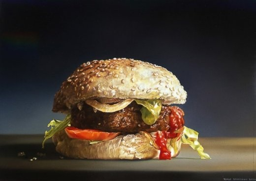

'tjalf-sparnaay-hyperrealistic-food-paintings-2-600x425.jpg'

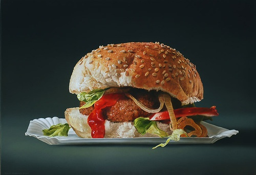

'Hyperrealistic painting by Dutch artist Tjalf Sparnaay'

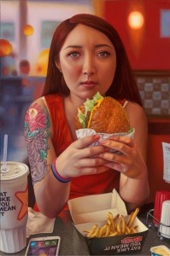

"Alex  Gross -  <strong>Eat Like You Mean It</strong> (2015<strong style = 'color:#635a27'></strong>)<bR />  oil on canvas,   25.75 x 17 inches  (65.4 x 43.2 cm),   framed dimensions 26.75 x 18 inches"

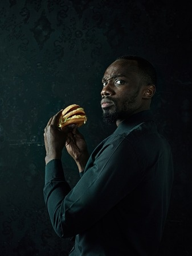

'The young african american man eating hamburger and looking away on black studio background'

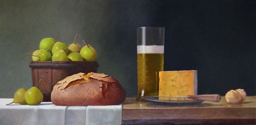

'lr_42863_bread_and_cheese_30cm_x_60cm_3_'

In [112]:
def find_nearest(features: torch.Tensor):
    similarity = torch.nn.functional.cosine_similarity(features, all_features)
    return similarity.sort(descending=True)

def display_nearest(features: torch.Tensor, n=5):
    similarity = find_nearest(features)
    for i in range(n):
        path = all_paths[similarity.indices[i]]
        image = Image.open(path)
        image.thumbnail((256,256))
        display(image)
        display(df.loc[path].caption)

display_nearest(get_text_features(["a cheeseburger"])[0])


In [121]:
pd.read_csv('/Users/damian/2.current/ozu/data/The Office complete Assets.csv')

,Path,AssetType,Director,Director.1,Director.2,Director.3,Director.4,Director.5,Episode Name,Episode Number,...,Writer.2,Writer.3,Writer.4,Writer.5,Writer.6,Writer.7,Writer.8,Writer.9,Year,WikipediaPageTitleOverride
0,/Users/damian/2.current/ozu/data/VideoArchiveSimulator/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S01E01.mp4,TV,Ken Kwapis,NaN,NaN,NaN,NaN,NaN,Pilot,1,...,Stephen Merchant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN
1,/Users/damian/2.current/ozu/data/VideoArchiveSimulator/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S01E02.mp4,TV,Ken Kwapis,NaN,NaN,NaN,NaN,NaN,Diversity Day,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN
2,/Users/damian/2.current/ozu/data/VideoArchiveSimulatore/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S04E01.mp4,TV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,Fun Run


In [114]:
df

,Path,AssetType,Director,Director.1,Director.2,Director.3,Director.4,Director.5,Episode Name,Episode Number,...,Writer.2,Writer.3,Writer.4,Writer.5,Writer.6,Writer.7,Writer.8,Writer.9,Year,WikipediaPageTitleOverride
0,/Users/damian/2.current/ozu/data/VideoArchiveSimulator/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S01E01.mp4,TV,Ken Kwapis,NaN,NaN,NaN,NaN,NaN,Pilot,1.0,...,Stephen Merchant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN
1,/Users/damian/2.current/ozu/data/VideoArchiveSimulator/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S01E02.mp4,TV,Ken Kwapis,NaN,NaN,NaN,NaN,NaN,Diversity Day,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,NaN
2,/Users/damian/2.current/ozu/data/VideoArchiveSimulator/VideoArchive/PrecordingReady/The Office complete/S1/The Office - S04E01.mp4,TV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,Fun Run


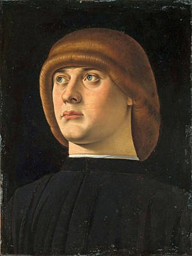

'Painting - Portrait Of A Young Man by Jacometto Veneziano'

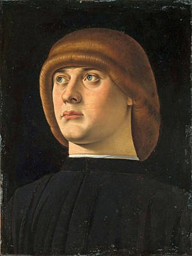

'Painting - Portrait Of A Young Man by Jacometto Veneziano'

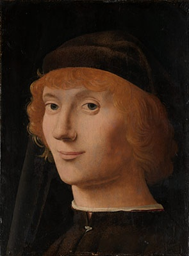

'Portrait of a Young Man'

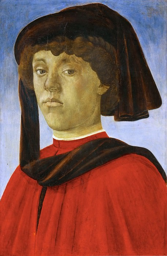

'Portrait of a young man. Alessandro Botticelli'

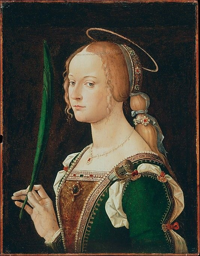

'Saint Justina of Padua  Bartolomeo Montagna (Bartolomeo Cincani)  (Italian, Vicentine, before 1459–1523)    Date:      1490s  Medium:      Oil on wood  Dimensions:      Overall, with added strips, 19 1/2 x 15 1/8 in. (49.5 x 38.4 cm); painted surface 19 1/8 x 14 3/4 in. (48.6 x 37.5 cm)  Classification:      Paintings  Credit Line:      Bequest of Benjamin Altman, 1913  Accession Number:      14.40.606'

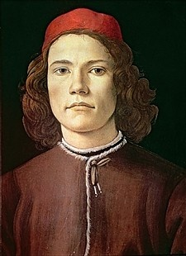

'Sandro Botticelli - Portrait of a Young Man'

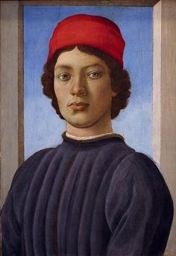

'Filippo Lippi (1406-1469, Italy) | Portrait of a Youth, 1485 (Washington, National Gallery of Art)'

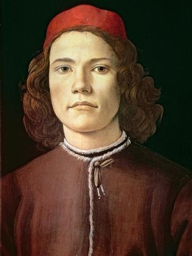

'Portrait of a Young Man, circa 1480-85'

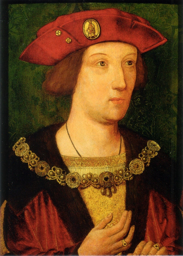

'Arthur Prince of Wales c 1500'

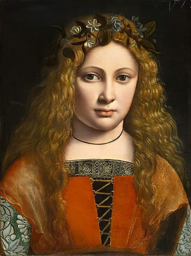

'Portrait of a Young Girl Crowned with Flowers, c.1490  by Giovanni Antonio Boltraffio'

In [145]:
def find_nearest(features: torch.Tensor):
    similarity = torch.nn.functional.cosine_similarity(features, all_features)
    return similarity.sort(descending=True)

def display_nearest(features: torch.Tensor, n=5):
    similarity = find_nearest(features)
    for i in range(n):
        try:
            path = all_paths[similarity.indices[i]]
            image = Image.open(path)
            image.thumbnail((256,256))
            display(image)
            display(df.loc[path].caption)
        except Exception as e:
            print('caught exception:', e)
            continue

display_nearest(get_text_features(["15th century figurative realism, female portrait"])[0], n=10)

In [146]:
clip_model.encode_text()

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se